In [1]:
import numpy as np
import os
import sys
import pandas as pd
sys.path.append(os.path.abspath("D:/other_thesis/codes_latestversion/general/codes/"))
import functions_model #import python file containing the functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
#import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score, mean_squared_error, mean_absolute_percentage_error
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math
import time
import seaborn as sns
from boruta import BorutaPy

import math
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

random.seed(1234) # Set random seed

In [2]:
# For updates
import importlib
importlib.reload(functions_model)

<module 'functions_model' from 'D:\\other_thesis\\codes_latestversion\\general\\codes\\functions_model.py'>

In [ ]:
data_paddy = gpd.read_file(r'D:\other_thesis\codes_latestversion\paddy\files\paddy_kharif_params_touched_large_final.geojson')

In [ ]:
dataset = data_paddy.copy()
data = dataset[dataset['Average Yield(Kg/Ha)'] != 0] # Throw away average yield values of zero, 13.366 datapoints left (6581 - 6556 = 25)
data = data[data['Gram Panchayat/Hobli'] == 'gp'] # 6058
#data = data.dropna(axis=0) # No missing values

In [ ]:
# We create dummies for the irrigation method, soil type and (previous) district yield.
irr_dummies = pd.get_dummies(data['IRR_RF']) # irrigation method dummies
irr_dummies = irr_dummies.rename(columns = {'irr': 'Irrigated'})

soiltype_dummies = pd.get_dummies(data['Soiltype_majority']) # soiltype dummies
soiltype_dummies = soiltype_dummies.rename(columns = {3.0: 'Soil_I', 4.0: 'Soil_Vp', 8.0: 'Soil_Rd', 17.0: 'Soil_WR', 20.0: 'Soil_Nd', 27.0: 'Soil_Bv', 33.0: 'Soil_Ne', 37.0: 'Soil_Vc', 39.0: 'Soil_Ap', 43.0: 'Soil_Lc'})

# The 8 types of soil in Karnataka:
# I: Lithosols
# Vp: Pellic Vertisols
# Rd: Dystric Regosols
# Lp: Plinthic Luvisols
# WR: Water Bodies
# Nd: Distric Nitosols
# Bv: Vertic Cambisols
# Ne: Eutric Nitosols
# Vc: Chromic Vertisols
# Ap: Plinthis Acrisols
# Lc: Chromic Luvisols

data = pd.concat([data, irr_dummies, soiltype_dummies], axis = 1)
data = data.drop(['rf', 'Soiltype_majority'], axis=1) # drop dummy which is not useful

In [ ]:
# Ratio of missing values per column
# If this ratio > 5%, we drop the column
ratios = []
cols = []
for i in range(11,383):
    if (data.iloc[:,i].isna().sum()/np.size(data,0)) >= 0.05: # 0.05
        cols.append(i)
        
data = data.drop(data.columns[cols],axis=1)
columns = list(data.columns)
np.size(data.dropna(),0) # 5350 (313), 4878, 5486 (241), 5550 (313)
data = data.dropna()

In [ ]:
data['Year'] = pd.to_datetime(data['Year'], format = '%Y') # Change Year column to datetime type
# NOTE: This dataset is already sorted wrt time, i.e., year 2016-2017-2018
#data = data.set_index('Year')

In [ ]:
train_geo = gpd.read_file(r'D:\other_thesis\final_run\files\train_geo.geojson')
test_geo = gpd.read_file(r'D:\other_thesis\final_run\files\test_geo.geojson')

In [9]:
# gp_train = gpd.GeoDataFrame()
# gp_test = gpd.GeoDataFrame()

# for i in data['District'].unique():
#     df_temp = data[data['District'] == i].copy()
#     gp_unique = df_temp.drop_duplicates(['shapeName', 'Taluk'])
#     gp_unique_train = gp_unique.sample(frac = 0.8, random_state = 1234)
#     gp_unique_test = gp_unique.drop(gp_unique_train.index)
#     gp_train = pd.concat([gp_train,gp_unique_train], ignore_index=True)
#     gp_test = pd.concat([gp_test,gp_unique_test], ignore_index=True)    

In [10]:
# gp_train #1743
# gp_test # 437

# train_geo = gpd.GeoDataFrame()
# test_geo = gpd.GeoDataFrame()
# for i in gp_train.index:
#     df_temp = data[(data['shapeName'] == gp_train.loc[i,'shapeName']) & (data['Taluk'] == gp_train.loc[i,'Taluk']) & (data['District'] == gp_train.loc[i,'District'])]
#     train_geo = pd.concat([train_geo,df_temp], ignore_index=True)

# for i in gp_test.index:
#     df_temp = data[(data['shapeName'] == gp_test.loc[i,'shapeName']) & (data['Taluk'] == gp_test.loc[i,'Taluk']) & (data['District'] == gp_test.loc[i,'District'])]
#     test_geo = pd.concat([test_geo,df_temp], ignore_index=True)

In [11]:
print(np.size(train_geo,0))
print(np.size(test_geo,0))
np.size(test_geo,0)/(np.size(test_geo,0)+np.size(train_geo,0))

# 4864
# 1189
# 0.19643152155955723

4864
1189


0.19643152155955723

In [12]:
print(min(train_geo['Average Yield(Kg/Ha)']))
print(max(train_geo['Average Yield(Kg/Ha)']))
print(np.mean(train_geo['Average Yield(Kg/Ha)']))
print(min(test_geo['Average Yield(Kg/Ha)']))
print(max(test_geo['Average Yield(Kg/Ha)']))
print(np.mean(test_geo['Average Yield(Kg/Ha)']))

# 4.26
# 12708.36
# 4147.067900904606
# 17.87
# 14594.31
# 4193.32402018503

4.26
12708.36
4147.067900904606
17.87
14594.31
4193.32402018503


In [13]:
# train_geo.to_file(r'D:\other_thesis\rf_model\files\train_geo.geojson', driver="GeoJSON")
# test_geo.to_file(r'D:\other_thesis\rf_model\files\test_geo.geojson', driver="GeoJSON")

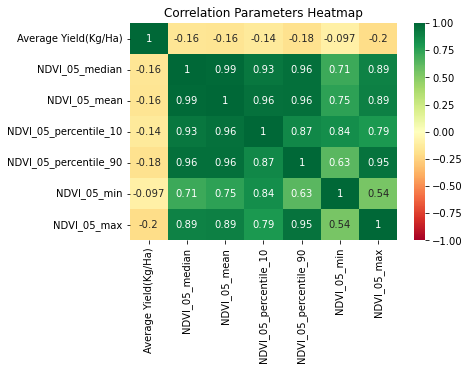

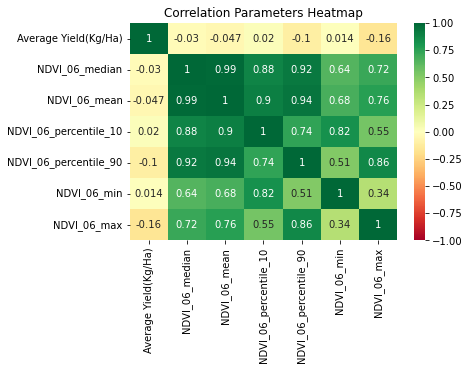

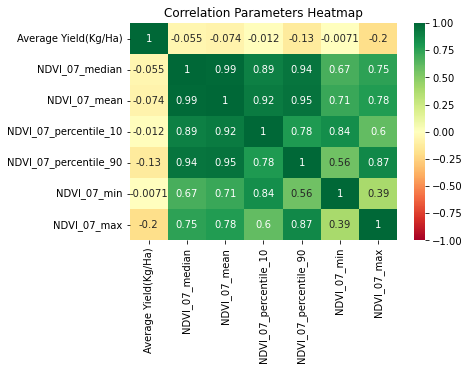

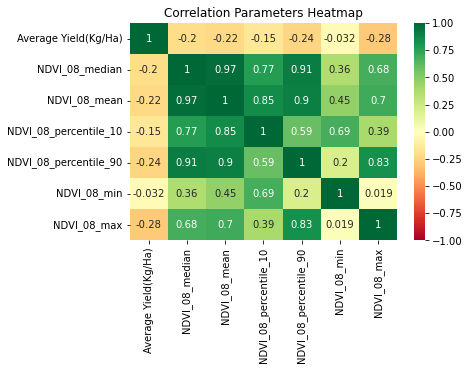

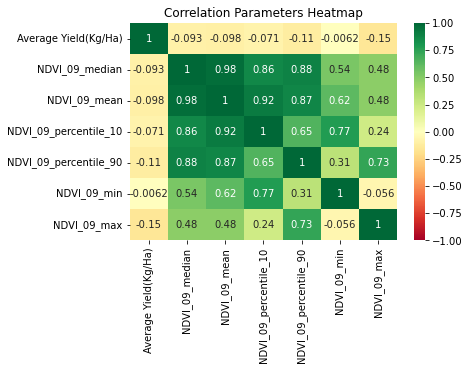

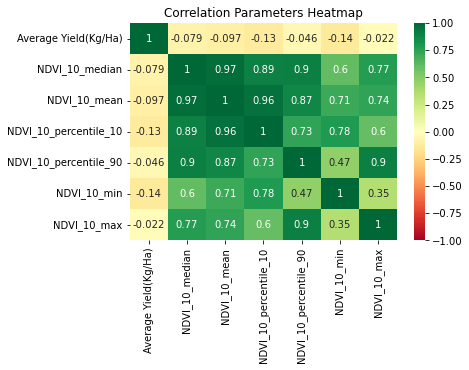

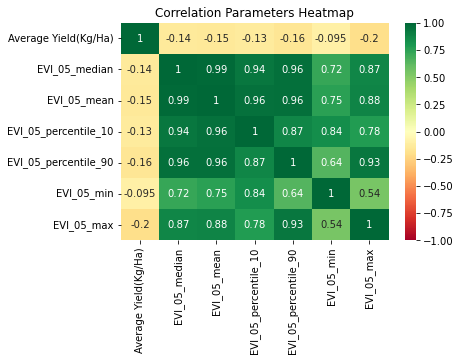

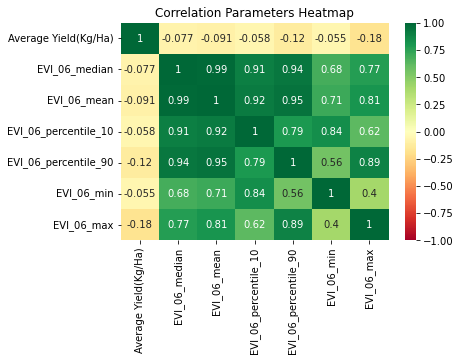

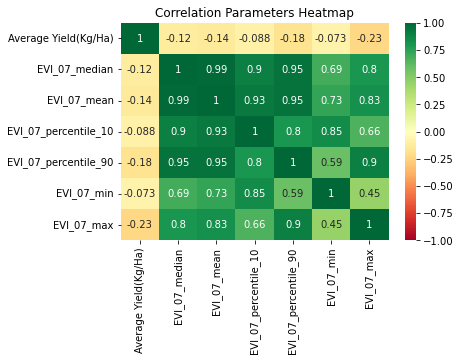

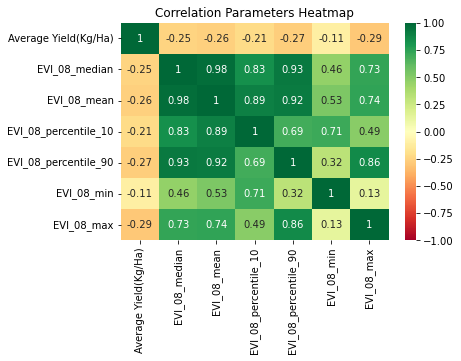

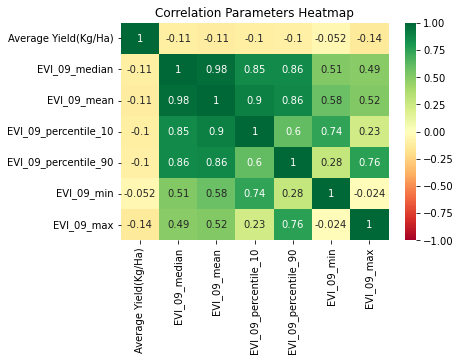

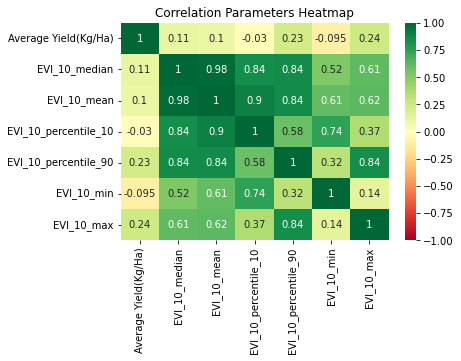

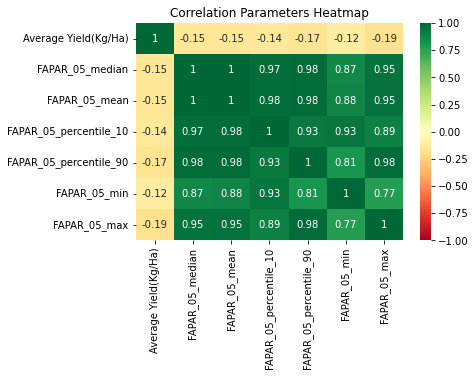

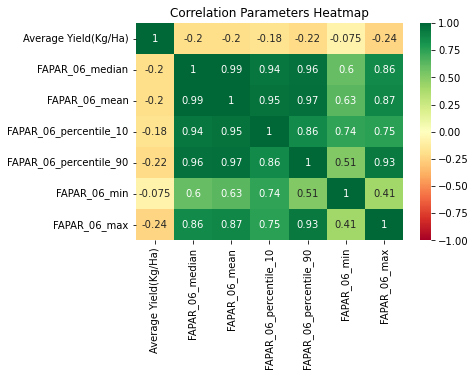

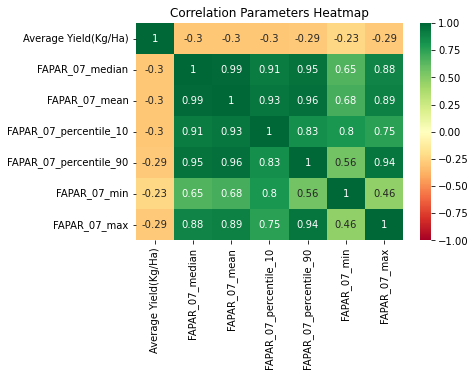

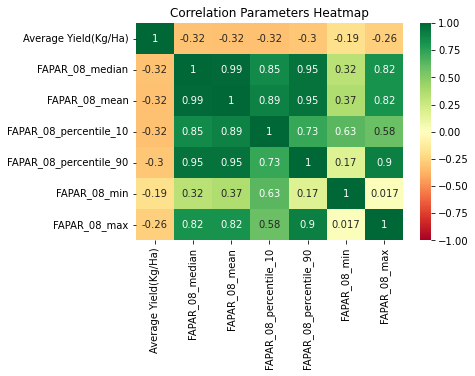

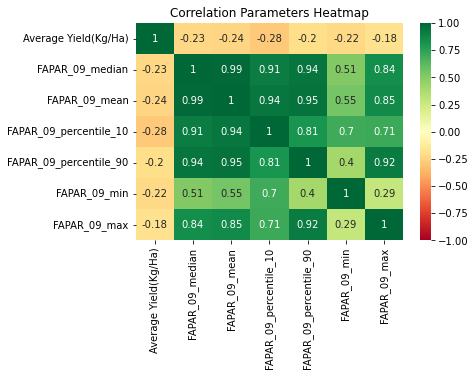

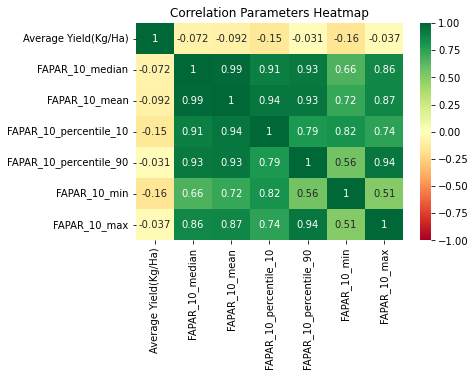

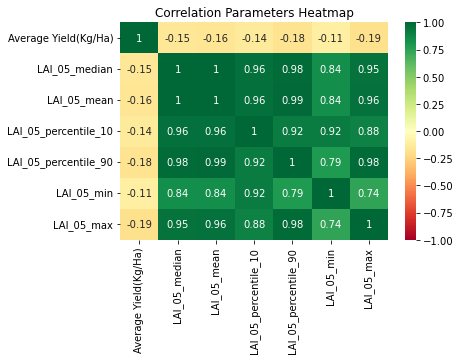

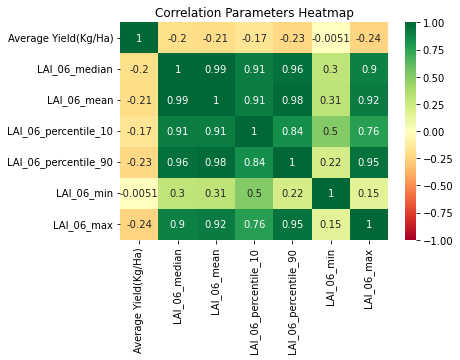

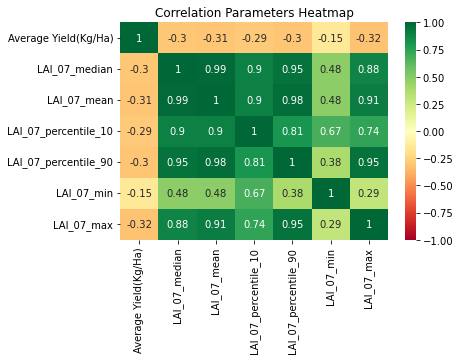

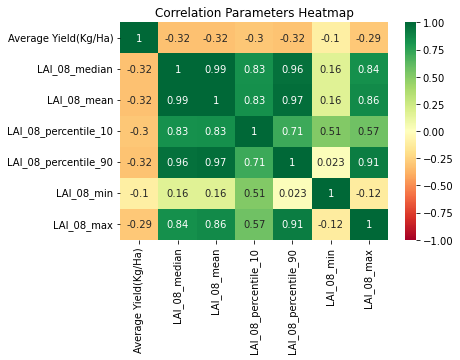

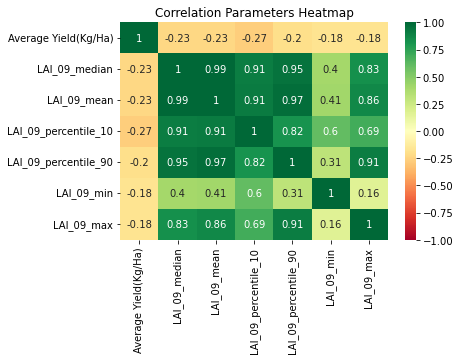

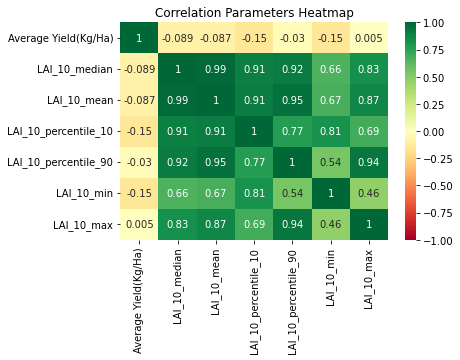

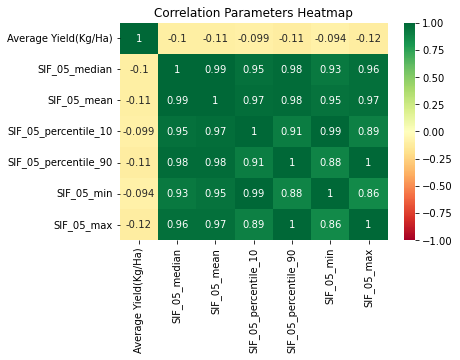

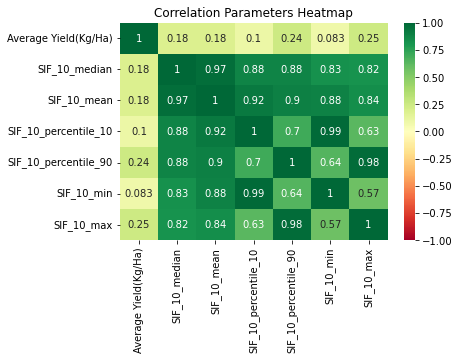

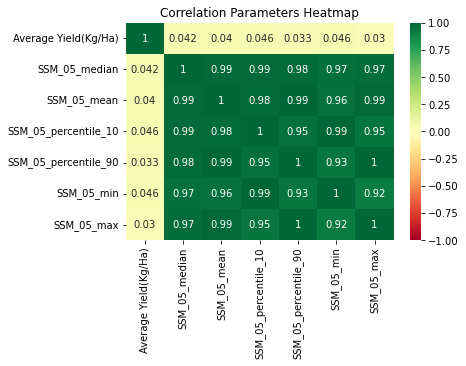

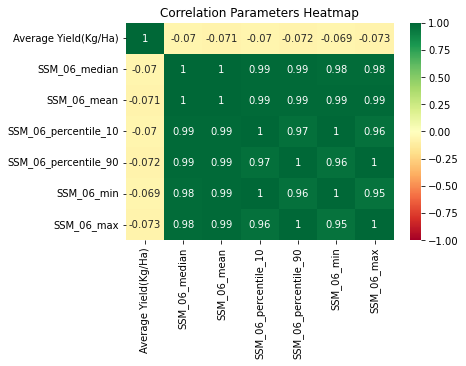

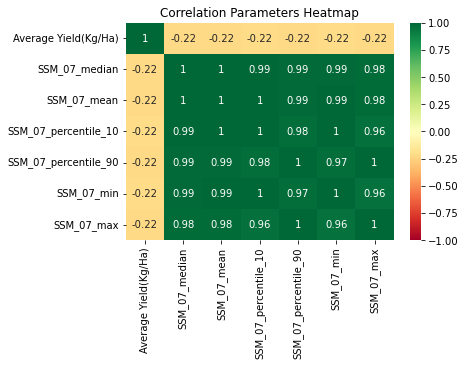

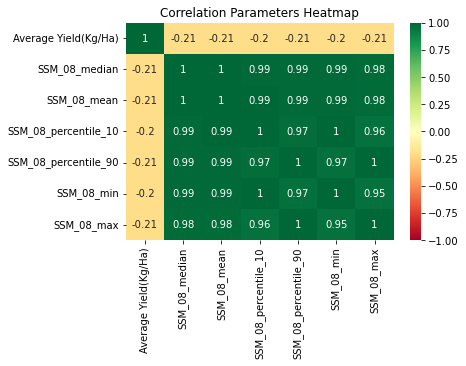

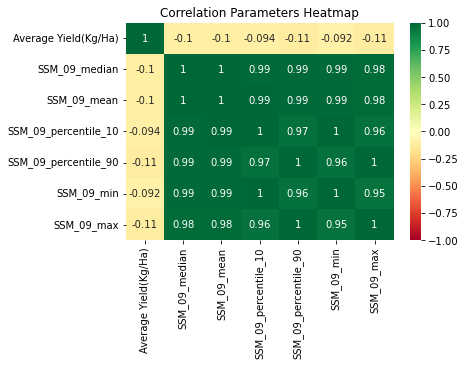

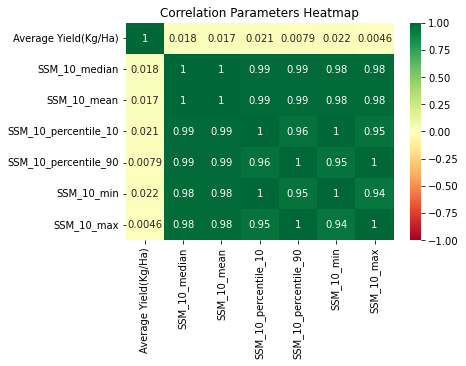

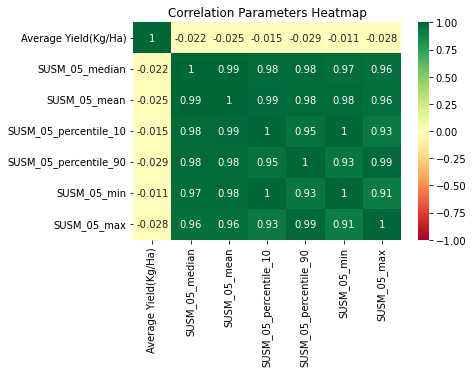

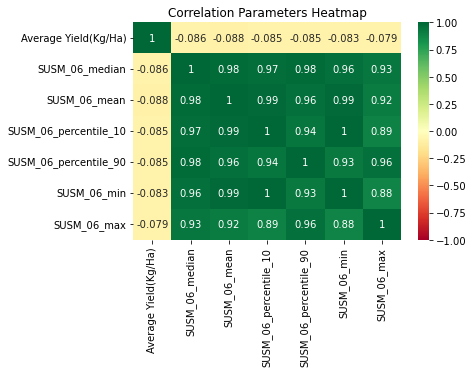

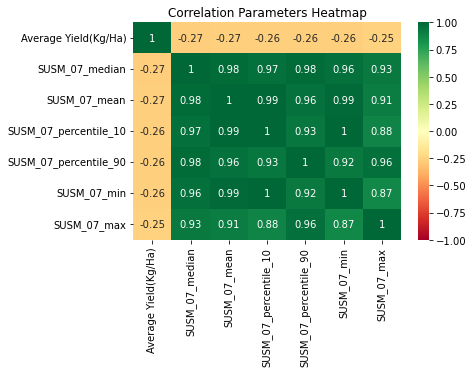

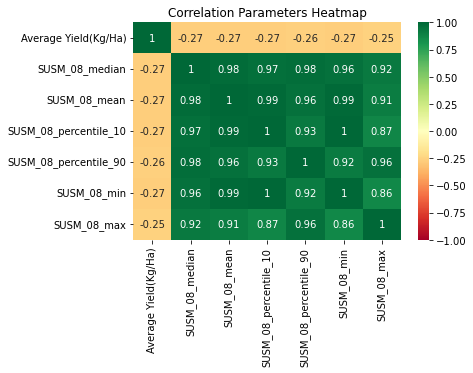

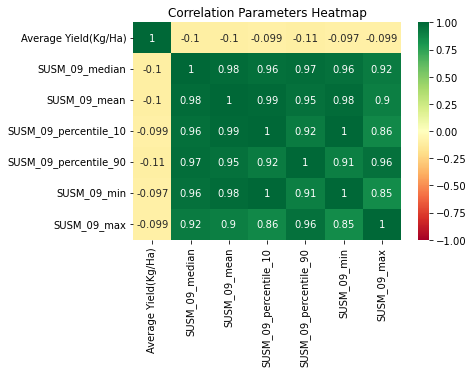

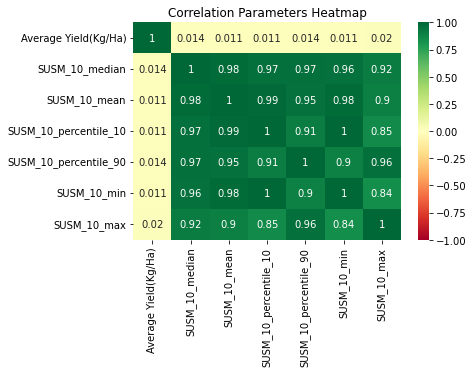

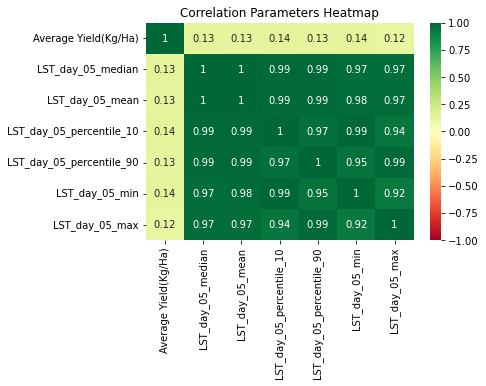

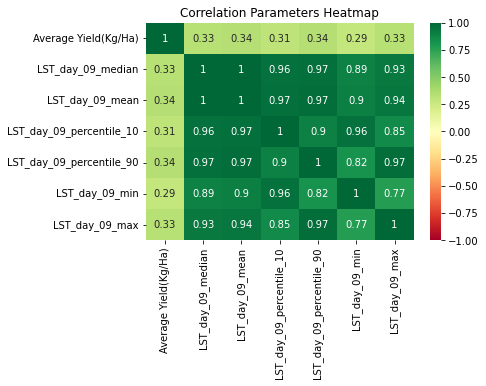

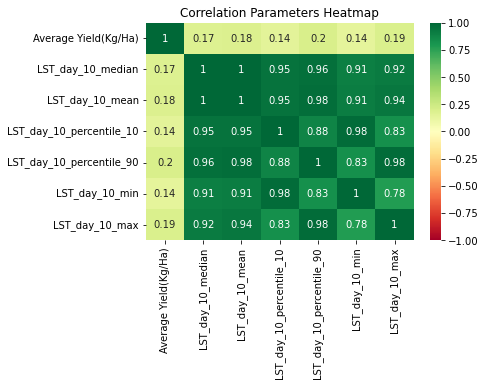

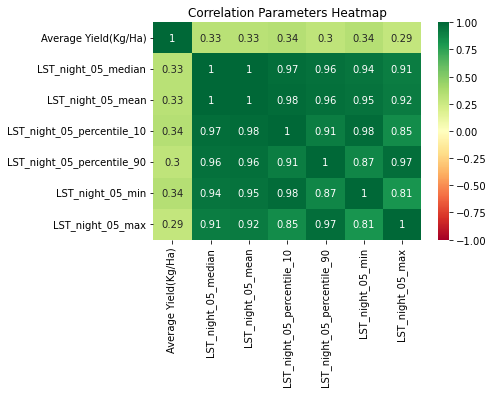

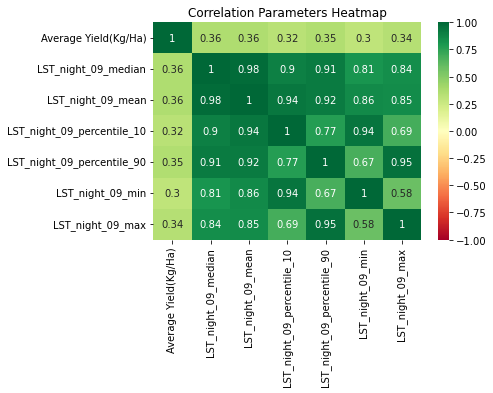

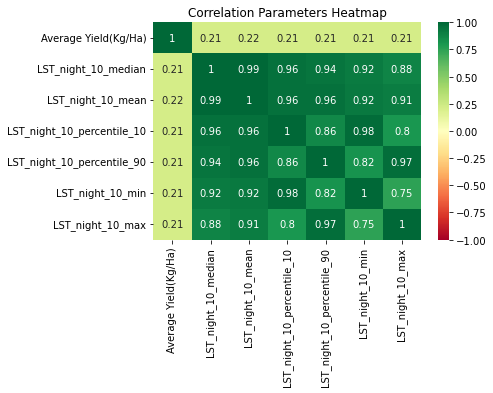

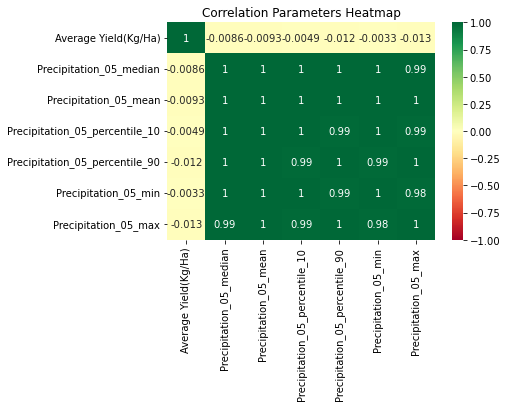

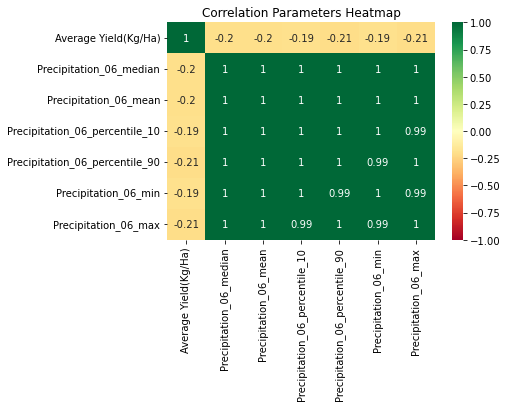

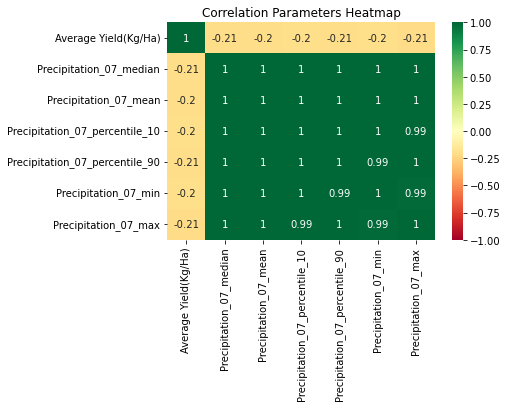

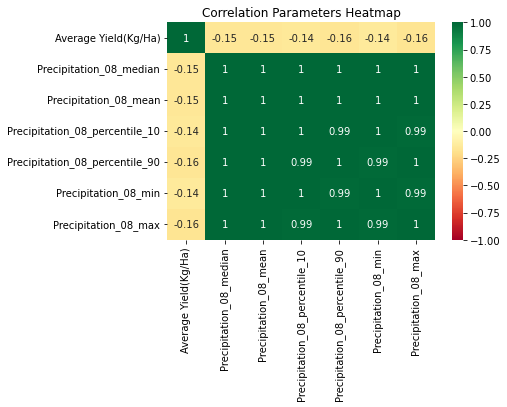

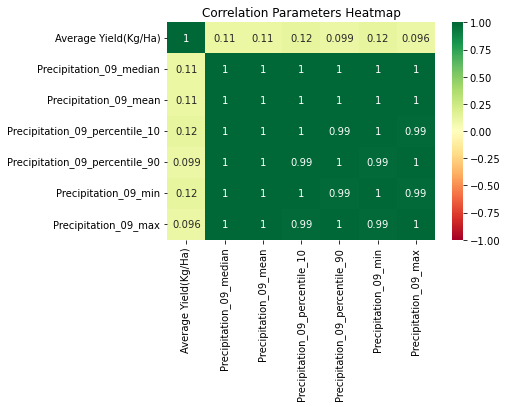

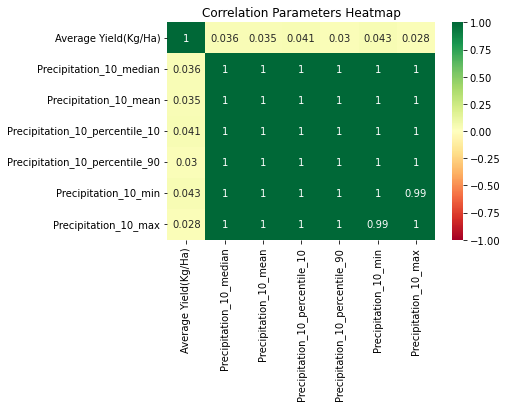

In [15]:
data_train = train_geo.copy()
variables_interest_train = []
for i in range(50):
    data_corr = pd.concat([data_train.loc[:,'Average Yield(Kg/Ha)'], data_train.iloc[:,(10+6*i):(16+6*i)]], axis=1)
    plt.figure(figsize=(6,4))
    heatmap = sns.heatmap(data_corr.corr(method = 'spearman'), vmin=-1, vmax=1, annot=True, cmap = 'RdYlGn')
    heatmap.set_title('Correlation Parameters Heatmap')
    plt.show()
    # Select the variable with the highest correlation with yield
    variables_interest_train.append(data_corr.corr(method = 'spearman').iloc[1:,0].abs().index[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs())])
    #if (data_corr.corr(method = 'spearman').iloc[1:,1:].abs() >= 0.8).sum().sum() != 36:
    # plt.figure(figsize=(4,4))
    # heatmap = sns.heatmap(data_corr.corr(method = 'spearman'), vmin=-1, vmax=1, annot=True, cmap = 'RdYlGn')
    # heatmap.set_title('Correlation Parameters Heatmap')
    # plt.show()
        #r += 1

    #if data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[data_corr.corr(method = 'spearman').iloc[1:,0].abs().index[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs())],1:]
    if np.min(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:]) < 0.8:
        #print(np.min(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:]))
        #variables_interest_train.append(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().loc[data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:].index[np.argmin(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:])],:].index[np.argmin(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().loc[data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:].index[np.argmin(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:])],:])])
        variables_interest_train.append(data_corr.corr(method = 'spearman').abs().loc[list(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().index[data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:] < 0.8]),'Average Yield(Kg/Ha)'].index[np.argmax(data_corr.corr(method = 'spearman').abs().loc[list(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().index[data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:] < 0.8]),'Average Yield(Kg/Ha)'])])

    #print(data_corr.corr(method = 'spearman').loc[data_corr.corr(method = 'spearman').iloc[1:,0].abs().index[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs())],:].index[np.argmin(data_corr.corr(method = 'spearman').iloc[:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:])])
    # if data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs()),:] < 0.8:
    #     variables_interest_train.append(data_corr.corr(method = 'spearman').iloc[1:,1:].abs().iloc[data_corr.corr(method = 'spearman').iloc[1:,0].abs().index[np.argmax(data_corr.corr(method = 'spearman').iloc[1:,0].abs())],:])
    

In [12]:
data = pd.concat([data.iloc[:,:10], data.geometry, data.loc[:,variables_interest_train], data.iloc[:,310], data.iloc[:,312:]], axis=1)
# ALS WE ALLES OPNIEUW RUNNEN
#data_train = pd.concat([data_train.iloc[:,:10], data_train.geometry, data_train.loc[:,variables_interest_train], data_train.iloc[:,310], data_train.iloc[:,312:]], axis=1)
# ALS WE INLADEN
data_train = pd.concat([data_train.iloc[:,:10], data_train.geometry, data_train.loc[:,variables_interest_train], data_train.iloc[:,310:-1]], axis=1)

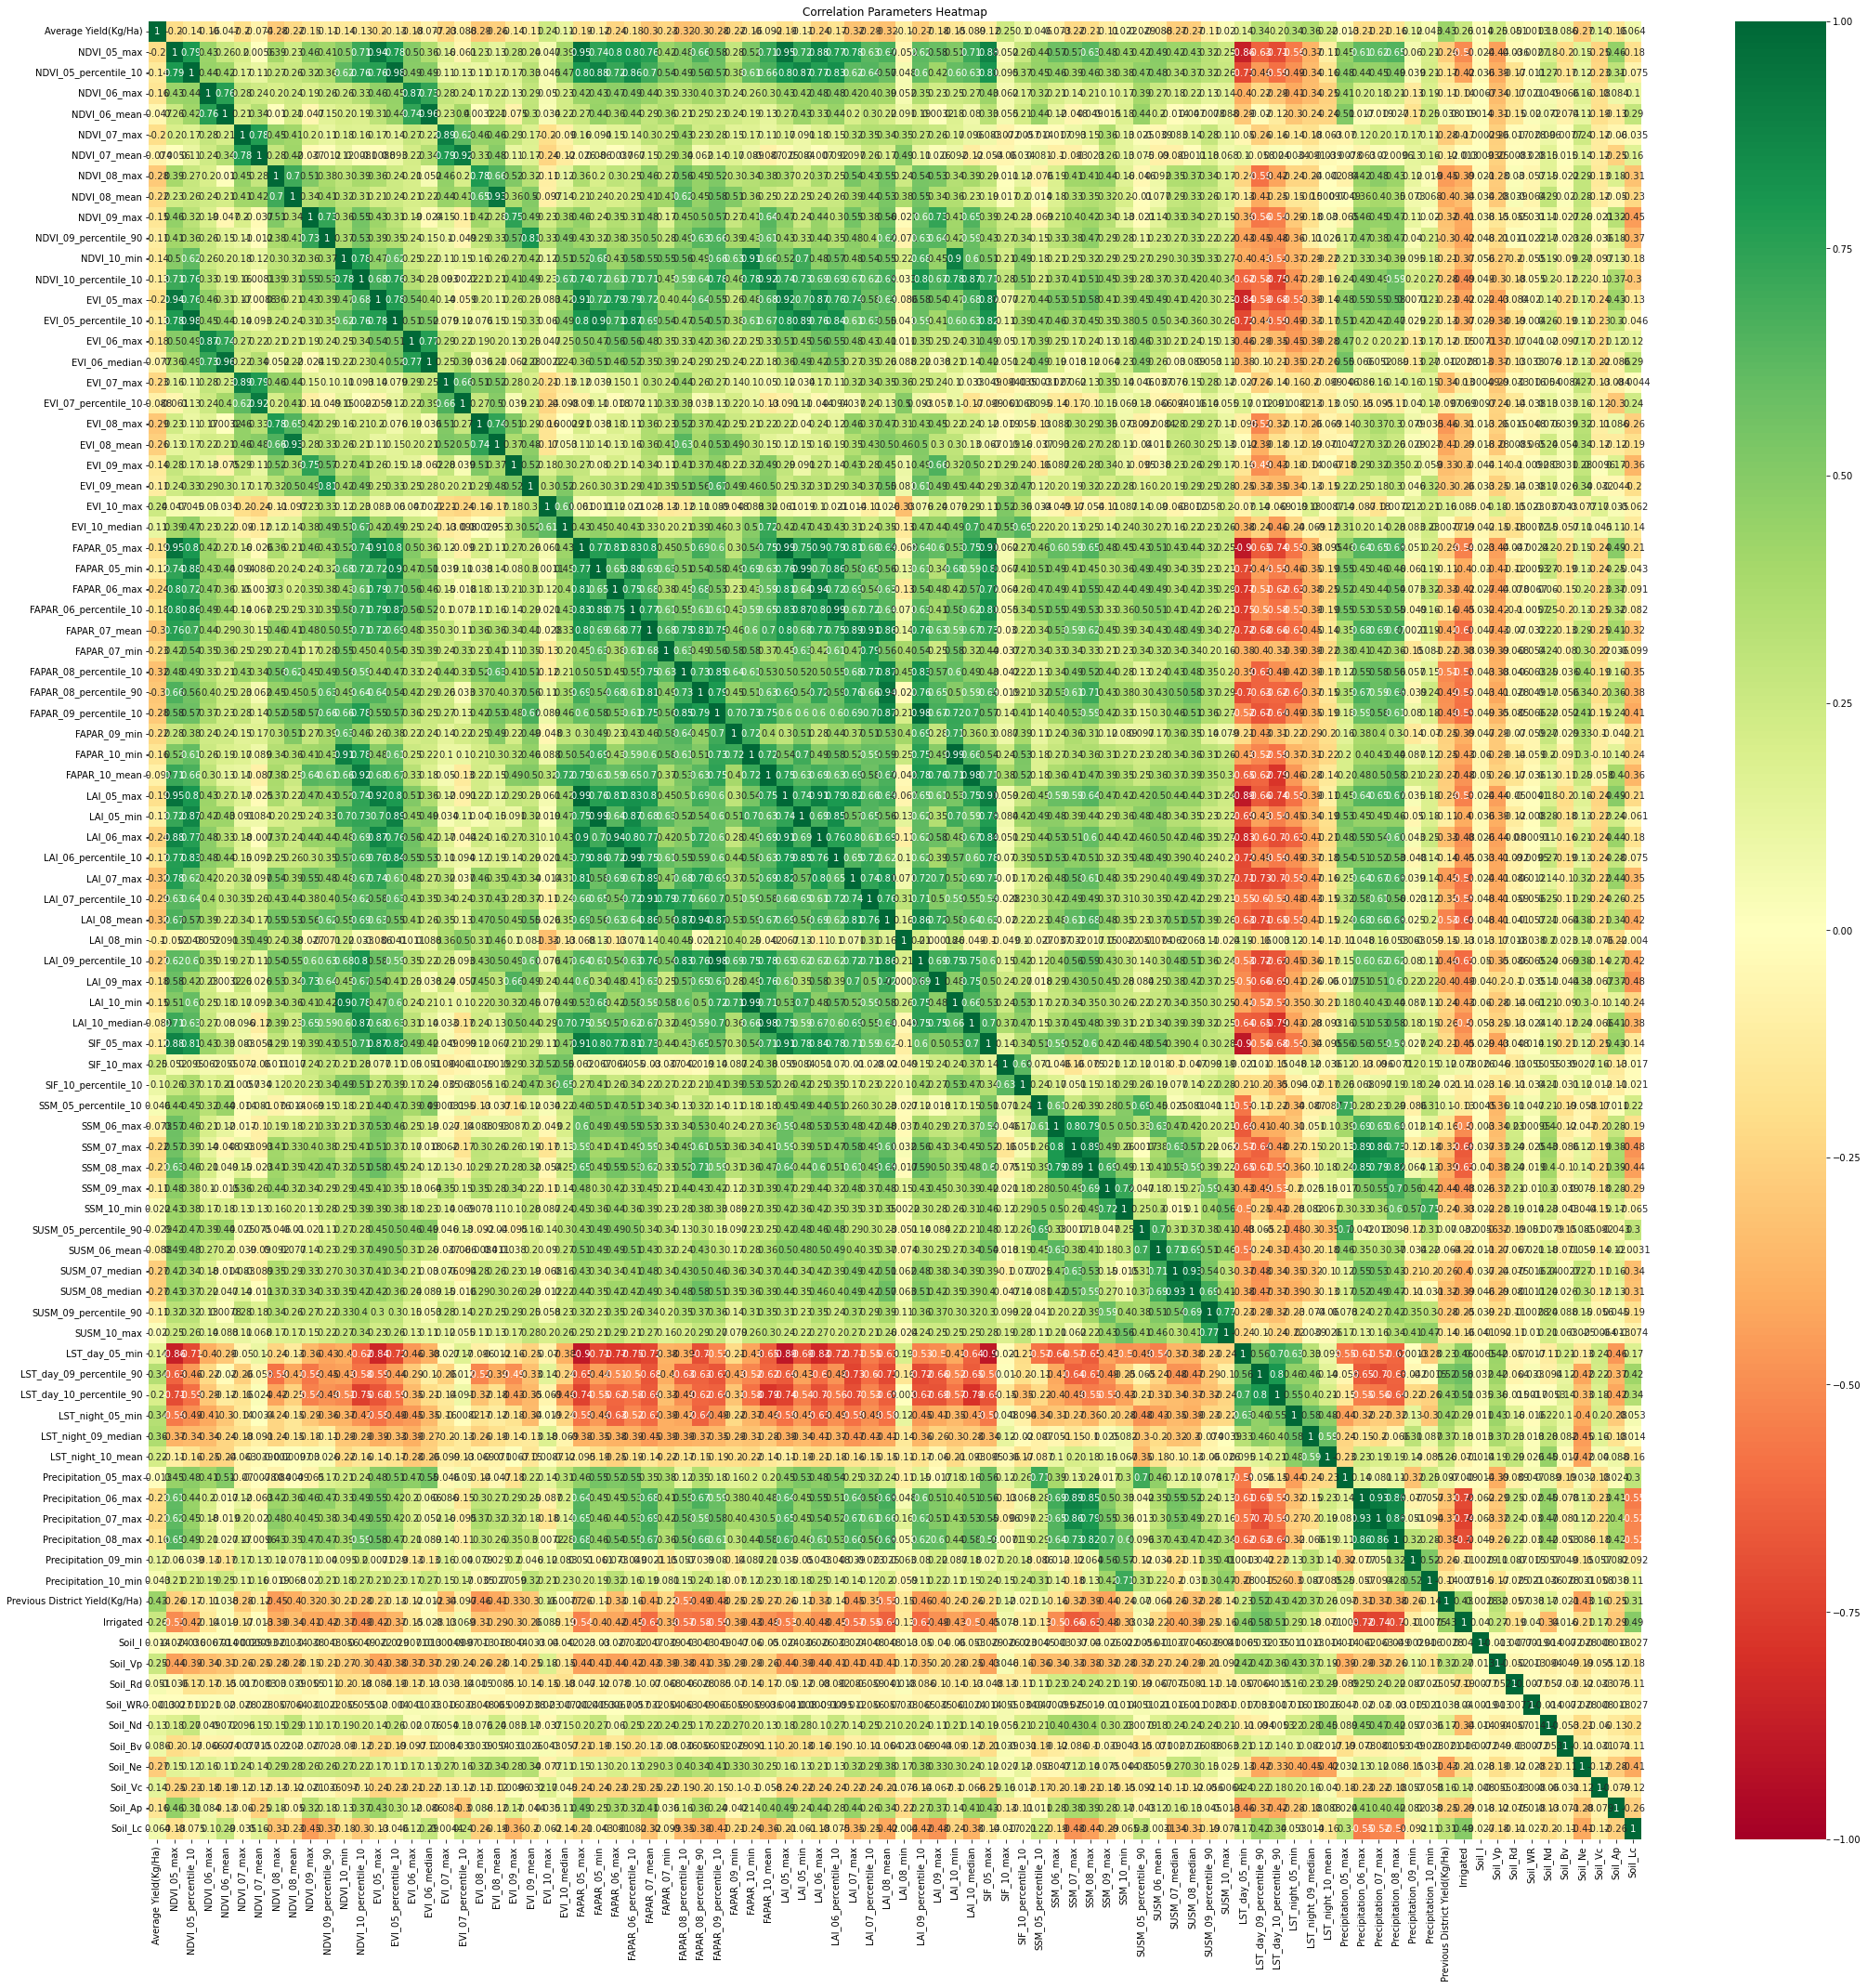

In [13]:
data_corr = pd.concat([data_train.loc[:,'Average Yield(Kg/Ha)'], data_train.iloc[:,11:]], axis=1)
plt.figure(figsize=(36,36))
heatmap = sns.heatmap(data_corr.corr(method = 'spearman'), vmin=-1, vmax=1, annot=True, cmap = 'RdYlGn')
heatmap.set_title('Correlation Parameters Heatmap')
plt.show()

In [14]:
# Maak een lijst met daarin alle variables
# Maak een correlation plot
# We gooien de variables weg die absolute correlation met yield hebben lager dan 0.01
# We checken welke variables hoge correlatie hebben met elkaar (> 0.85)
# Voor deze set houden we alleen degene die de hoogste correlatie heeft met yield, de andere gooien we dus weg
#variables = list(data.iloc[:,10:].columns)
#variables.remove('geometry')
variables = list(data_train.columns)[11:]
data_corr = data_train.copy()
#data_corr = pd.concat([data.loc[:,'Average Yield(Kg/Ha)'], data.loc[:,variables]], axis=1)
outcomes_corr = data_corr.corr(method = 'spearman').iloc[0,:] # correlations with yield
excess = list(outcomes_corr[(abs(outcomes_corr) <= 0.01) == True].index)

for x in excess:
    variables.remove(x)
    print(x)

Soil_WR


In [15]:
data_corr = pd.concat([data_train.loc[:,'Average Yield(Kg/Ha)'], data_train.loc[:,variables]], axis=1)
params_corr = data_corr.corr(method = 'spearman').abs()
#params_corr.iloc[0,1]
sol = (params_corr.where(np.triu(np.ones(params_corr.shape), k=1).astype(bool)).stack().sort_values(ascending=False))
sol_80 = sol[sol >= 0.80]

In [16]:
removed = pd.DataFrame()
removed['Pairs'] = list(sol_80.index)
removed['Kept'] = np.nan
removed['Lost'] = np.nan
for i in range(len(sol_80)):
    if params_corr.loc[sol_80.index[i][0],'Average Yield(Kg/Ha)'] > params_corr.loc[sol_80.index[i][1],'Average Yield(Kg/Ha)'] and (sol_80.index[i][1] in variables) == True:
        variables.remove(sol_80.index[i][1])
        removed.loc[i,'Kept'] = str(sol_80.index[i][0])
        removed.loc[i,'Lost'] = str(sol_80.index[i][1])
        print('We remove ', sol_80.index[i][1], ' for ', sol_80.index[i][0])
        
    elif params_corr.loc[sol_80.index[i][1],'Average Yield(Kg/Ha)'] > params_corr.loc[sol_80.index[i][0],'Average Yield(Kg/Ha)'] and (sol_80.index[i][0] in variables) == True:  
        variables.remove(sol_80.index[i][0])
        removed.loc[i,'Kept'] = str(sol_80.index[i][1])
        removed.loc[i,'Lost'] = str(sol_80.index[i][0])
        print('We remove ', sol_80.index[i][0], ' for ', sol_80.index[i][1])

# print(sol_80.index[i], sol_80[i])
# Vind correlatie tussen 

We remove  FAPAR_05_max  for  LAI_05_max
We remove  LAI_10_min  for  FAPAR_10_min
We remove  LAI_05_min  for  FAPAR_05_min
We remove  LAI_06_percentile_10  for  FAPAR_06_percentile_10
We remove  LAI_10_median  for  FAPAR_10_mean
We remove  LAI_09_percentile_10  for  FAPAR_09_percentile_10
We remove  EVI_05_percentile_10  for  NDVI_05_percentile_10
We remove  NDVI_06_mean  for  EVI_06_median
We remove  LAI_05_max  for  NDVI_05_max
We remove  FAPAR_08_percentile_90  for  LAI_08_mean
We remove  EVI_05_max  for  NDVI_05_max
We remove  FAPAR_06_max  for  LAI_06_max
We remove  SUSM_07_median  for  SUSM_08_median
We remove  NDVI_08_mean  for  EVI_08_mean
We remove  Precipitation_06_max  for  Precipitation_07_max
We remove  FAPAR_10_mean  for  NDVI_10_percentile_10
We remove  NDVI_07_mean  for  EVI_07_percentile_10
We remove  SIF_05_max  for  FAPAR_05_max
We remove  LAI_07_percentile_10  for  FAPAR_07_mean
We remove  NDVI_10_min  for  FAPAR_10_min
We remove  FAPAR_05_min  for  EVI_05_percentil

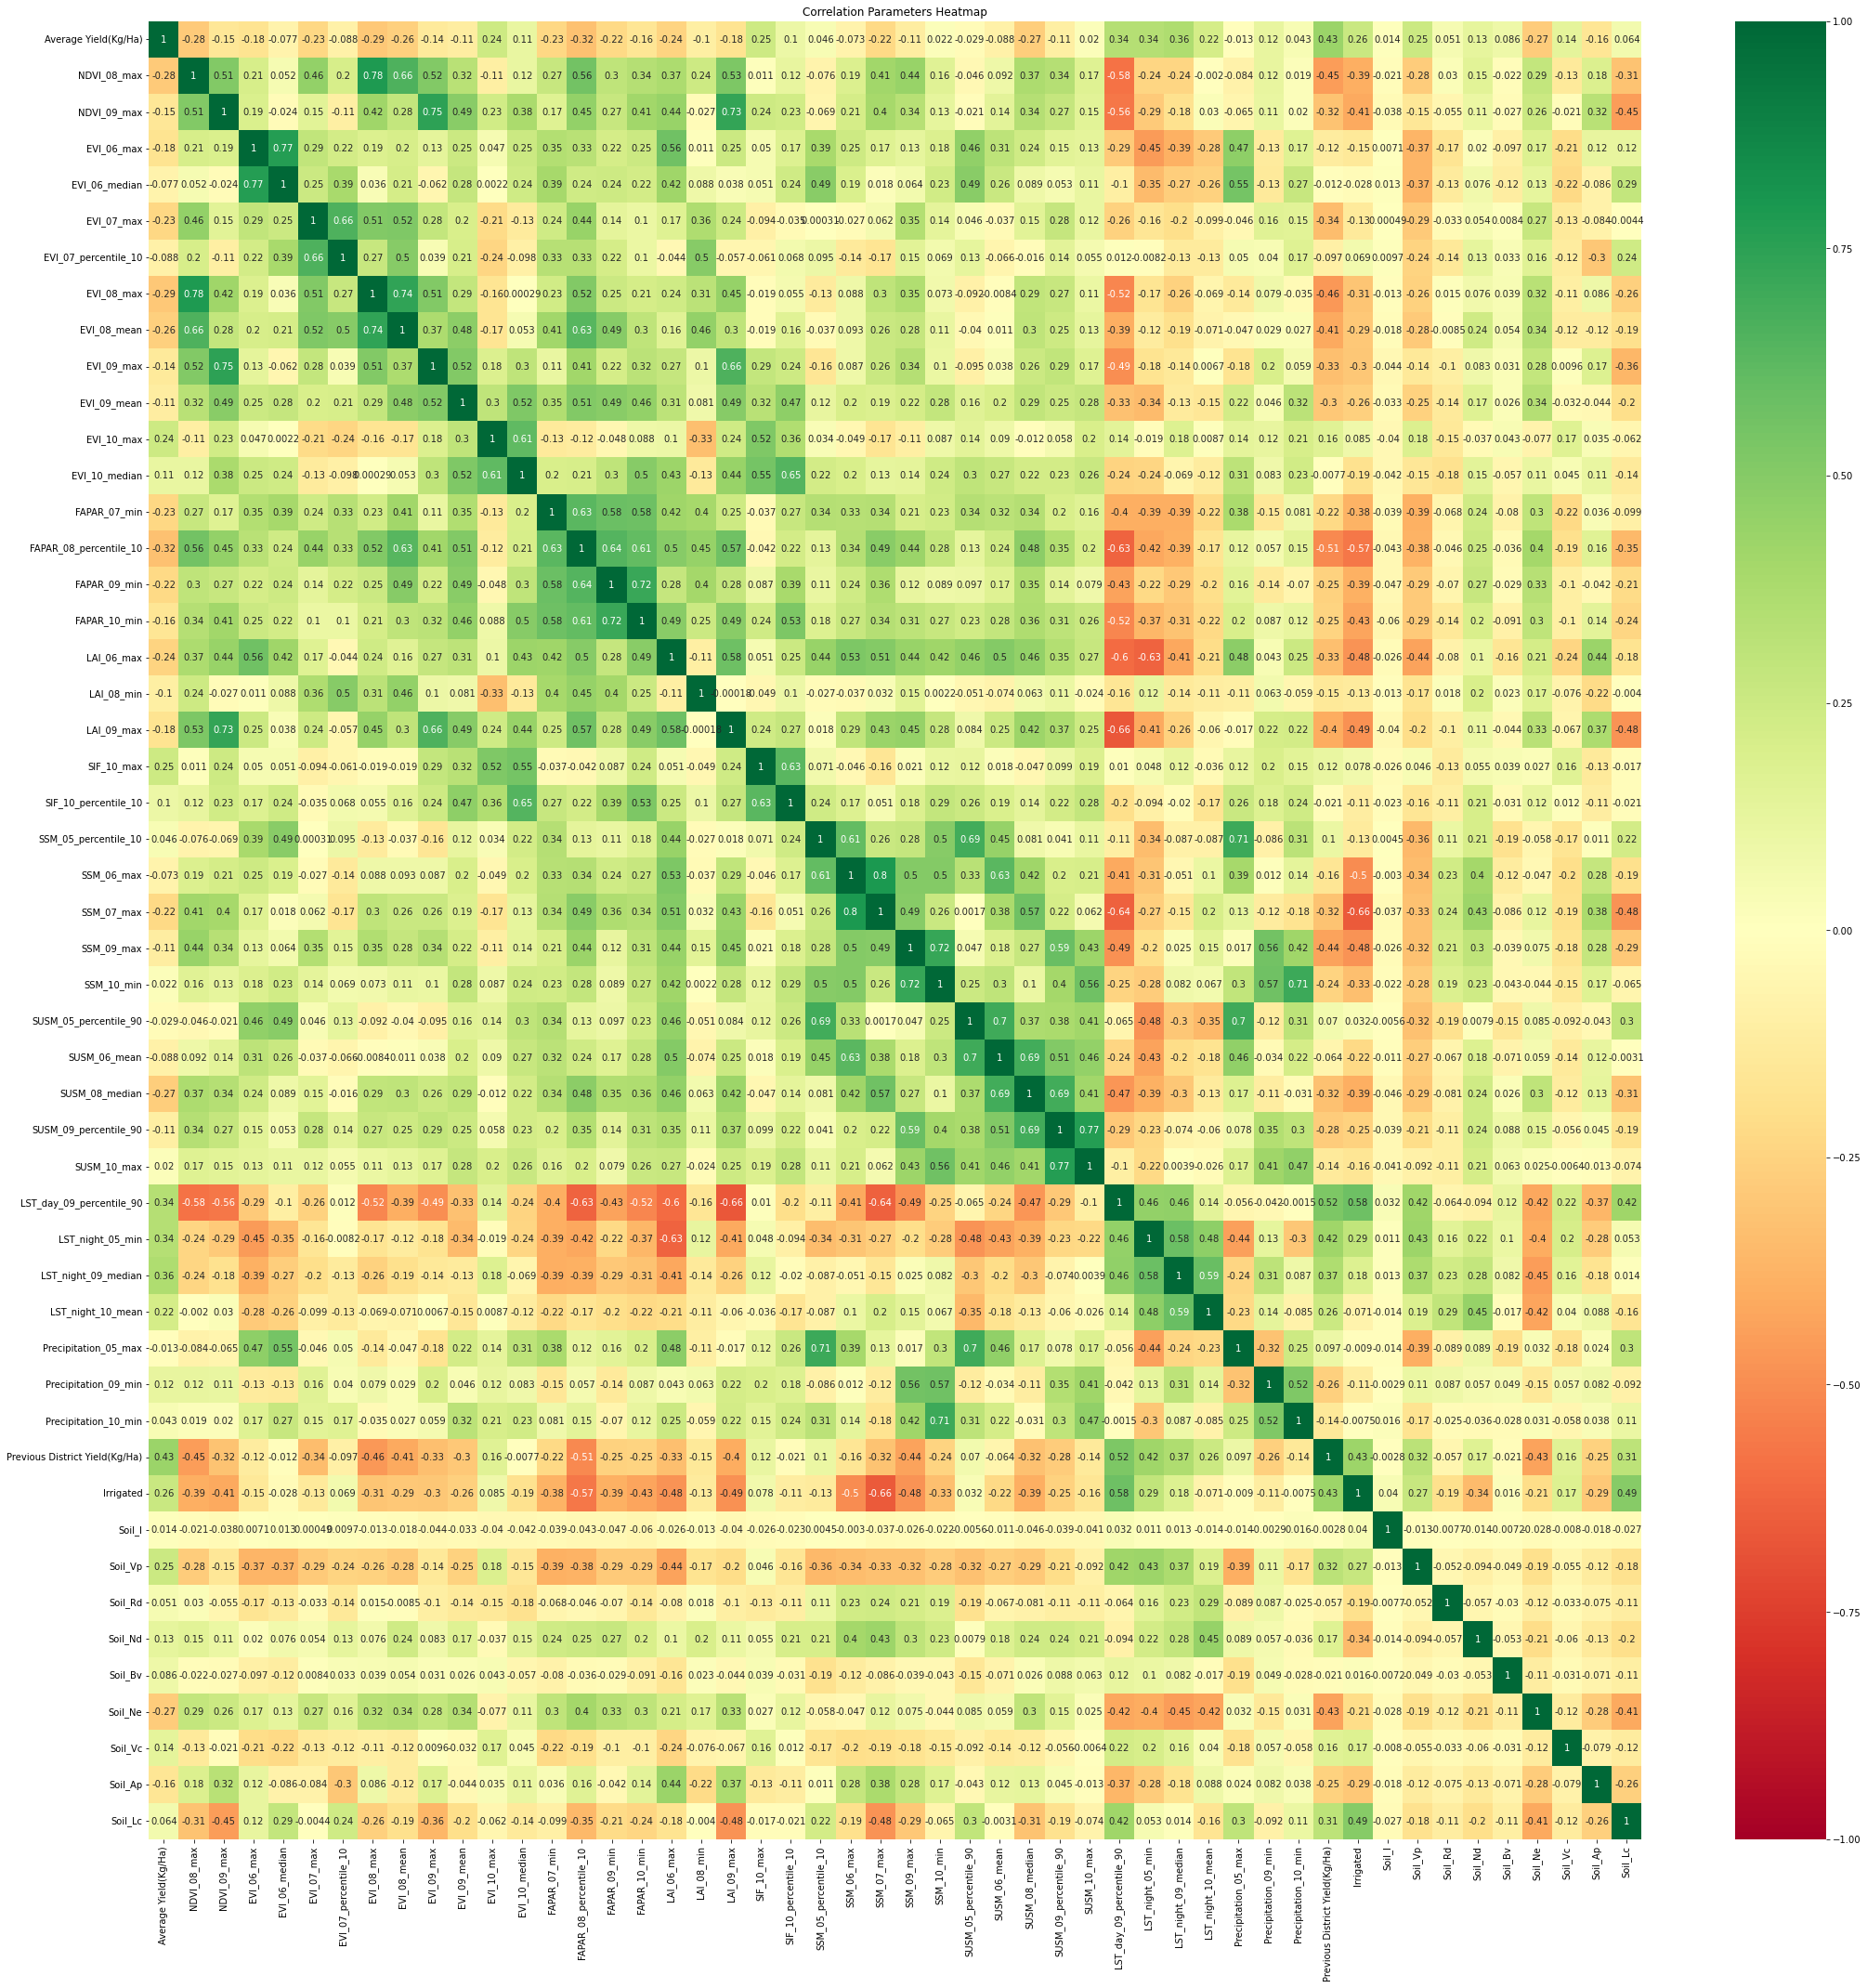

In [17]:
data_corr = pd.concat([data_train.loc[:,'Average Yield(Kg/Ha)'], data_train.loc[:,variables]], axis=1)
plt.figure(figsize=(36,36))
heatmap = sns.heatmap(data_corr.corr(method = 'spearman'), vmin=-1, vmax=1, annot=True, cmap = 'RdYlGn')
heatmap.set_title('Correlation Parameters Heatmap')
plt.show()

In [18]:
## ONNODIG
outcomes_corr = data_corr.corr(method = 'spearman').iloc[0,:] # correlations with yield
excess = list(outcomes_corr[(abs(outcomes_corr) <= 0.01) == True].index)

for x in excess:
    variables.remove(x)
    print(x)

In [19]:
variables_set = pd.DataFrame(columns = ['Feature', 'Sets'])#{'Feature': np.nan, 'Set': np.nan})
variables_set['Sets'] =  pd.Series([[] for i in range(len(variables))])
variables_set['Feature'] = variables
for i in variables:
    params_corr.iloc[list(params_corr.columns)[:].index(i),:]
    variables_set.loc[variables.index(i),'Sets'].append(list(params_corr.loc[i,:][params_corr.loc[i,:] >= 0.8].index))

In [20]:
variables_set.to_excel(r'D:\other_thesis\rf_model\files\variables_set_geo.xlsx', index = False)

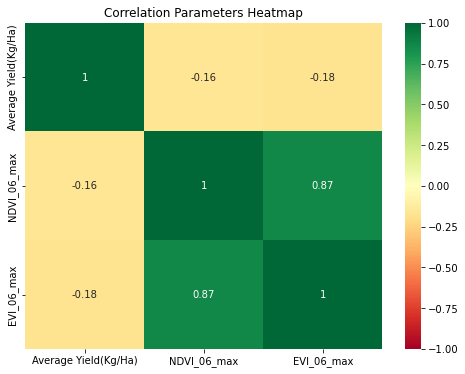

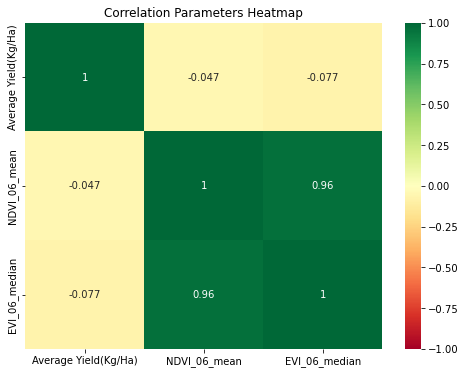

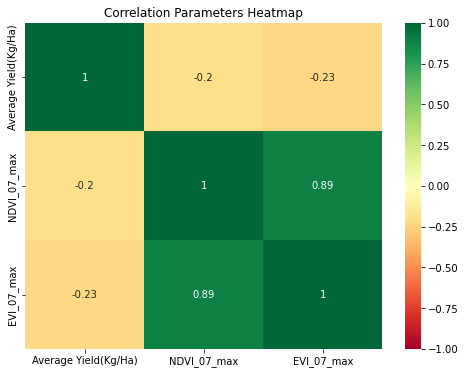

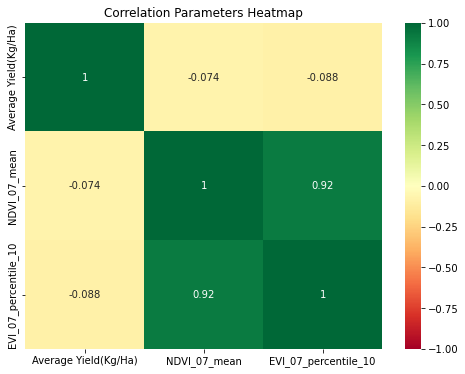

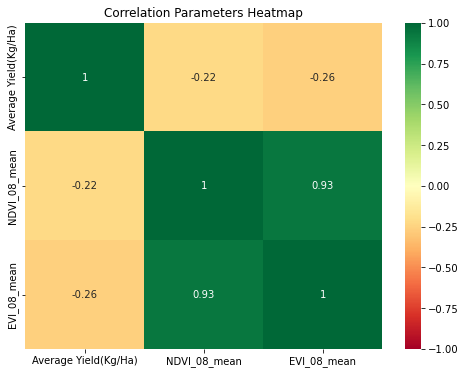

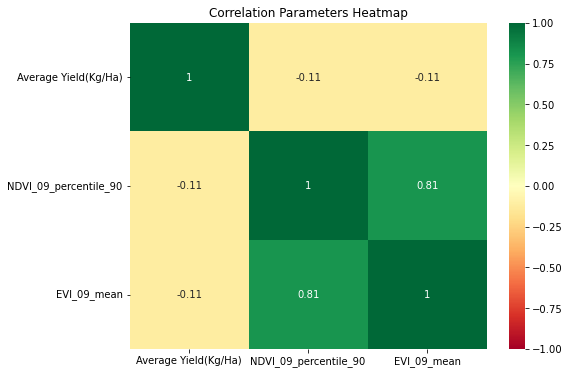

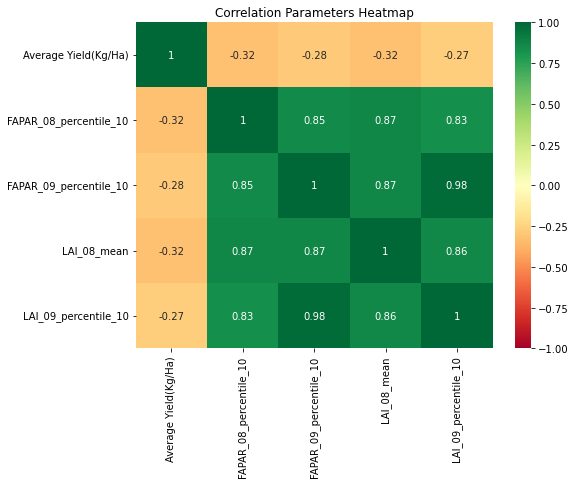

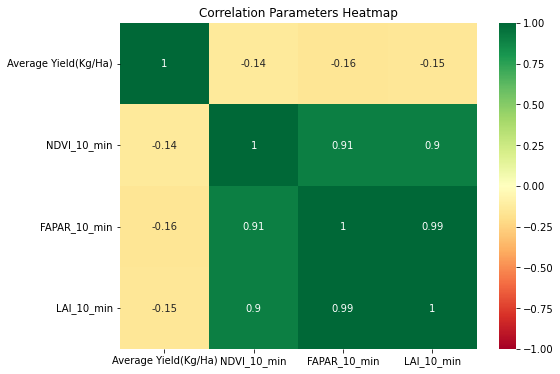

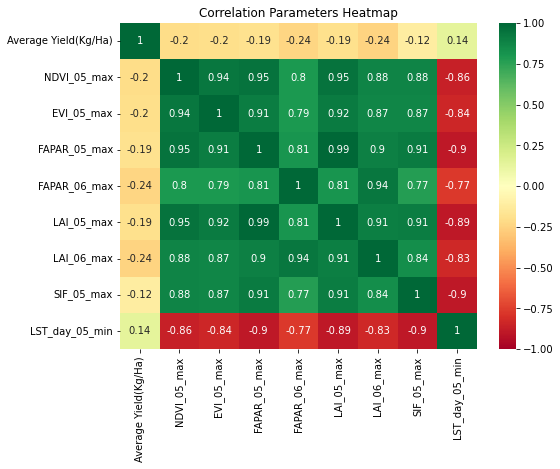

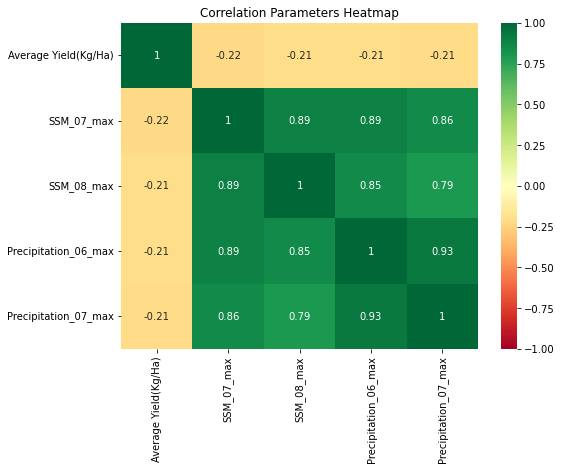

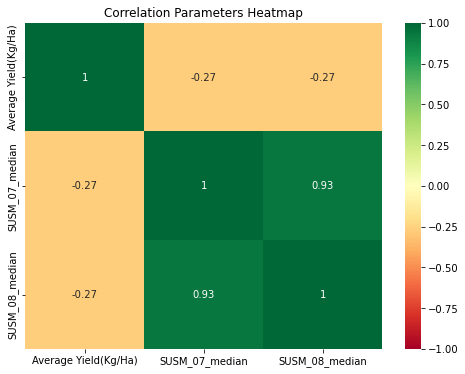

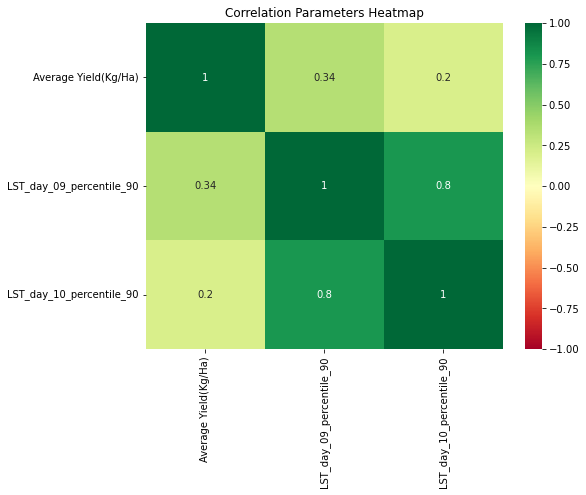

In [21]:
for i in range(np.size(variables_set,0)):
    if len(variables_set.loc[i,'Sets'][0]) > 1:
        data_corr = pd.concat([data_train.loc[:,'Average Yield(Kg/Ha)'], data_train.loc[:,variables_set.loc[i,'Sets'][0]]], axis=1)
        plt.figure(figsize=(8,6))
        heatmap = sns.heatmap(data_corr.corr(method = 'spearman'), vmin=-1, vmax=1, annot=True, cmap = 'RdYlGn')
        heatmap.set_title('Correlation Parameters Heatmap')
        plt.show()

In [21]:
data = pd.concat([data.iloc[:,:10], data.geometry, data.loc[:,variables]], axis=1)
data_train = pd.concat([data_train.iloc[:,:10], data_train.geometry, data_train.loc[:,variables]], axis=1)

In [22]:
init_paramset = functions_model.RandomSearch(np.arange(300, 1301, 250).tolist(), [math.ceil(len(variables)/3)], [3, 5, 7], [2, 5, 10, 15, 20], [1, 2, 4, 6, 8], [True], 5, train_geo, 'Average Yield(Kg/Ha)', variables, 250)
print('RandomSearch finished.') # Binnen de 30 min
print(init_paramset)
update_paramset = functions_model.GridSearch(init_paramset, 5, train_geo, 'Average Yield(Kg/Ha)', variables)
print('First GridSearch finished.') # 70 min
print(update_paramset)
updated_paramset = functions_model.GridSearch(update_paramset, 5, train_geo, 'Average Yield(Kg/Ha)', variables)

RandomSearch finished.
{'n_estimators': 550, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 17, 'max_depth': 7, 'bootstrap': True}
First GridSearch finished.
{'bootstrap': True, 'max_depth': 8, 'max_features': 17, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 600}


In [23]:
print('init_paramset \n', init_paramset)
print('update_paramset \n', update_paramset)
print('updated_paramset \n', updated_paramset)

# init_paramset 
#  {'n_estimators': 550, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 17, 'max_depth': 7, 'bootstrap': True}
# update_paramset 
#  {'bootstrap': True, 'max_depth': 8, 'max_features': 17, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 600}
# updated_paramset 
#  {'bootstrap': True, 'max_depth': 9, 'max_features': 17, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 750}

init_paramset 
 {'n_estimators': 550, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 17, 'max_depth': 7, 'bootstrap': True}
update_paramset 
 {'bootstrap': True, 'max_depth': 8, 'max_features': 17, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 600}
updated_paramset 
 {'bootstrap': True, 'max_depth': 9, 'max_features': 17, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 750}


In [22]:
updated_paramset = {'bootstrap': True, 'max_depth': 9, 'max_features': 17, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 750}

In [23]:
opt_features = variables
n_estimators_ = updated_paramset['n_estimators']
max_depth_ = updated_paramset['max_depth']
bootstrap_ = updated_paramset['bootstrap']
min_samples_leaf_ = updated_paramset['min_samples_leaf']
min_samples_split_ = updated_paramset['min_samples_split']

In [24]:
X_train = train_geo[opt_features]
X_test = test_geo[opt_features]
Y_train = train_geo['Average Yield(Kg/Ha)']
Y_test = test_geo['Average Yield(Kg/Ha)']

max_features_optimal = math.ceil(len(opt_features)/3)
if max_features_optimal == 0:
    max_features_optimal = 1

# Set parameters equal to the optimal parameters found
clf = RandomForestRegressor(n_estimators = n_estimators_, max_depth = max_depth_, bootstrap = bootstrap_, max_features = max_features_optimal, min_samples_leaf = min_samples_leaf_, min_samples_split = min_samples_split_, random_state = 1234)

#Fit to the training data
clf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=9, max_features=17, min_samples_leaf=4,
                      min_samples_split=4, n_estimators=750, random_state=1234)

In [25]:
predictions_train = clf.predict(X_train)
R2_train = r2_score(Y_train, predictions_train)
RMSE_train = mean_squared_error(Y_train, predictions_train, squared=False)
MAPE_train = mean_absolute_percentage_error(Y_train,predictions_train)
MAE_train = mean_absolute_error(Y_train,predictions_train)
print('R2: ', R2_train)
print('RMSE: ', RMSE_train)
print('MAPE: ', MAPE_train)
print('MAE: ', MAE_train)

# R2:  0.6920034146459977
# RMSE:  927.9416453491391
# MAPE:  0.3355056530126273
# MAE:  700.1598101097816

R2:  0.6920034146459977
RMSE:  927.9416453491391
MAPE:  0.3355056530126273
MAE:  700.1598101097816


In [26]:
predictions_test = clf.predict(X_test)
R2_test = r2_score(Y_test, predictions_test)
RMSE_test = mean_squared_error(Y_test, predictions_test, squared=False)
MAPE_test = mean_absolute_percentage_error(Y_test,predictions_test)
MAE_test = mean_absolute_error(Y_test,predictions_test)
print('R2: ', R2_test)
print('RMSE: ', RMSE_test)
print('MAPE: ', MAPE_test)
print('MAE: ', MAE_test)

# R2:  0.5126383486582025
# RMSE:  1202.7107557622546
# MAPE:  0.4595317528449611
# MAE:  886.8084443970944

R2:  0.5126383486582025
RMSE:  1202.7107557622546
MAPE:  0.4595317528449611
MAE:  886.8084443970944


In [27]:
# Wat ik wil opslaan: features, afbeeldingen, df_subset, train dataframe met predictions en geometry, test dataframe met predictions en geometry
df_train = train_geo.copy()
df_train['Y_pred'] = predictions_train
df_train['abs_diff'] = abs(df_train['Average Yield(Kg/Ha)'] - df_train['Y_pred'])

df_test = test_geo.copy()
df_test['Y_pred'] = predictions_test
df_test['abs_diff'] = abs(df_test['Average Yield(Kg/Ha)'] - df_test['Y_pred'])

# df_train.to_file(r'D:\other_thesis\rf_model\files\df_train_geo.geojson', driver="GeoJSON")
# df_test.to_file(r'D:\other_thesis\rf_model\files\df_test_geo.geojson', driver="GeoJSON")

In [35]:
import json
with open(r'D:\other_thesis\rf_model\files\variables_geo.json', 'w') as fp:
    json.dump(variables, fp)

In [50]:
def plot_max_depth(df, target):
    df = df.sort_values(by='max_depth')
    max_depth = df['max_depth'].to_list()
    plt.figure(figsize=(10,10))
    plt.plot(max_depth, df['R2_test'], c = 'red', label='test')
    plt.plot(max_depth, df['R2_train'], c = 'green', label='train')
    #plt.title(target + ' R2 Test and Training Data')
    plt.xlabel('max depth', fontsize=15)
    plt.ylabel('R2', fontsize=15)
    plt.legend()
    plt.show()

    return()

In [37]:
def RandomForestRegressionModel(hyperparams, data, train_data, test_data, variables_sel, target, cv_method):

    array_X = np.array(data[variables_sel])
    array_Y = np.array(data[target])

    MAE_folds = []
    R2_folds = []
    RMSE_folds = []

    for train_index, test_index in cv_method.split(train_data):

        
        #print('TRAIN:', train_index, 'TEST', test_index) 
        x_train, x_test = array_X[train_index], array_X[test_index]
        y_train, y_test = array_Y[train_index], array_Y[test_index]

        if hyperparams['max_features'] !='auto':
            hyperparams['max_features'] = math.ceil(len(variables_sel)/3)
            if hyperparams['max_features'] == 0:
                hyperparams['max_features'] = 1


        clf = RandomForestRegressor(n_estimators=hyperparams['n_estimators'], max_depth=hyperparams['max_depth'], bootstrap = hyperparams['bootstrap'], max_features = hyperparams['max_features'], min_samples_leaf = hyperparams['min_samples_leaf'], min_samples_split = hyperparams['min_samples_split'], random_state = 1234)

        #Fit to the training data
        clf.fit(x_train, y_train)

        #Make a prediction on the test data
        predictions = clf.predict(x_test)

        #Calculate mean absolute error
        MAE_folds.append(mean_absolute_error(y_test, predictions))
    
        #MAPE
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)

        #RMSE
        RMSE_folds.append(mean_squared_error(y_test, predictions, squared=False))

        #R2
        R2_folds.append(r2_score(y_test, predictions))
        #print(R2_folds)

    
    clf_full = RandomForestRegressor(n_estimators=hyperparams['n_estimators'], max_depth=hyperparams['max_depth'], bootstrap = hyperparams['bootstrap'], max_features = hyperparams['max_features'], min_samples_leaf = hyperparams['min_samples_leaf'], min_samples_split = hyperparams['min_samples_split'], random_state = 1234)
    #Fit to the training data
    clf_full.fit(train_data[variables_sel], train_data[target])

    #Make a prediction on the test data
    predictions_full = clf_full.predict(test_data[variables_sel])

    MAE = [sum(MAE_folds)/len(MAE_folds), mean_absolute_error(test_data[target], predictions_full)]
    RMSE = [sum(RMSE_folds)/len(RMSE_folds),  mean_squared_error(test_data[target], predictions_full, squared=False)]
    R2 = [sum(R2_folds)/len(R2_folds), r2_score(test_data[target], predictions_full)]

    return(clf_full, MAE, RMSE, R2)

In [45]:
maxdepths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
target = 'Average Yield(Kg/Ha)'
# k_fold = 4
# btscv = BlockingTimeSeriesSplit(n_splits = k_fold)
# updated_paramset = df_findings['Parameters'][0]
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

#updated_paramset['min_samples_split'] = 5
parameter_scores = []
x = 0
parameters = updated_paramset.copy()
parameters['max_features'] = math.ceil(len(variables)/3)
for depth in maxdepths:
    
    parameters['max_depth'] = depth

    rf_model, MAE, RMSE, R2 = RandomForestRegressionModel(parameters, data, train_data = train_geo, test_data = test_geo, variables_sel = variables, target = 'Average Yield(Kg/Ha)', cv_method = kf)

    predictions_train = rf_model.predict(train_geo[variables])

    MAE_train = mean_absolute_error(train_geo['Average Yield(Kg/Ha)'], predictions_train)
    RMSE_train = mean_squared_error(train_geo[target], predictions_train, squared=False)
    R2_train = r2_score(train_geo['Average Yield(Kg/Ha)'], predictions_train)

    parameter_scores.append((x, MAE[1], RMSE[1], R2[1], MAE_train, RMSE_train, R2_train, variables, depth))
x = x + 1
results = pd.DataFrame(parameter_scores, columns = ['Feature_set', 'MAE_test', 'RMSE_test', 'R2_test', 'MAE_train', 'RMSE_train', 'R2_train', 'Features', 'max_depth'])


In [48]:
results.to_excel(r'D:\other_thesis\rf_model\files\depth_geo.xlsx', header=True, index=True)

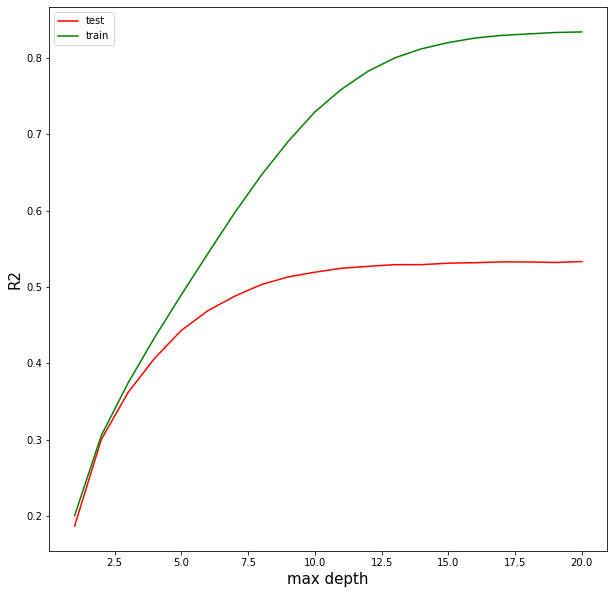

()

In [51]:
plot_max_depth(results, 'Average Yield(Kg/Ha)')

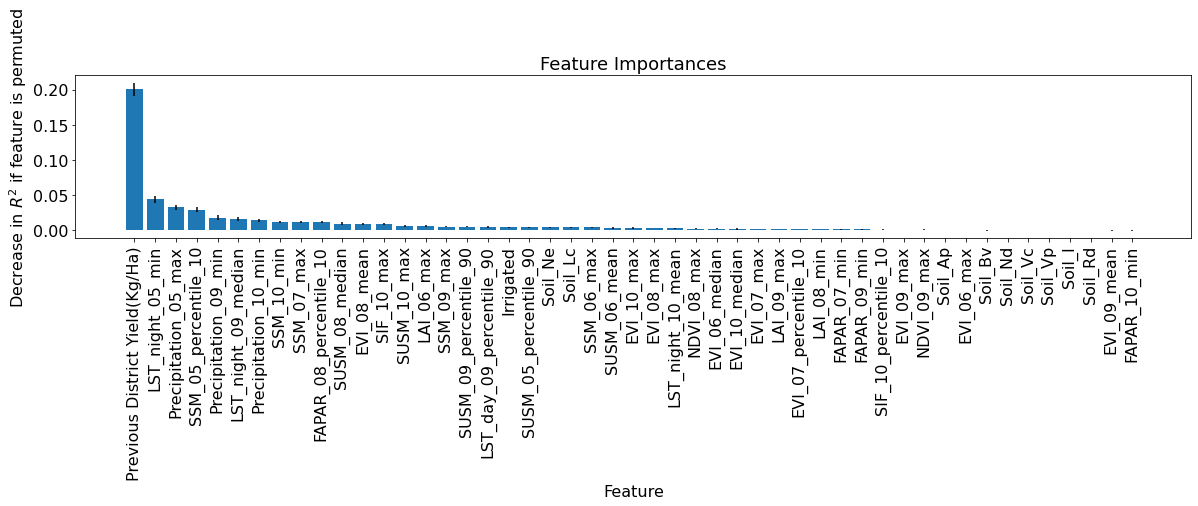

[('Previous District Yield(Kg/Ha)', 0.200826212821627, 0.009256101474242774),
 ('LST_night_05_min', 0.043699355405974, 0.005165313255966231),
 ('Precipitation_05_max', 0.032926121086113, 0.003601909144917337),
 ('SSM_05_percentile_10', 0.029161007761205, 0.003568192425006286),
 ('Precipitation_09_min', 0.017867491336127, 0.003945270165504383),
 ('LST_night_09_median', 0.015601600640629, 0.00260004715950421),
 ('Precipitation_10_min', 0.013985649436619, 0.0018582434974573148),
 ('SSM_10_min', 0.011451851774701, 0.001460034353759585),
 ('SSM_07_max', 0.011156308270145, 0.0015238439998702556),
 ('FAPAR_08_percentile_10', 0.011146063150216, 0.0013824861625532372),
 ('SUSM_08_median', 0.009001680260651, 0.0022910222203843303),
 ('EVI_08_mean', 0.008761955521751, 0.001125598888641034),
 ('SIF_10_max', 0.008744183737669, 0.00196837530374229),
 ('SUSM_10_max', 0.00613646629541, 0.0010849451048520664),
 ('LAI_06_max', 0.005905017841214, 0.0015090550099431802),
 ('SSM_09_max', 0.005250428268373,

In [28]:
functions_model.permutation_importances(clf, variables, 'Average Yield(Kg/Ha)', test_geo, 'D:/other_thesis/rf_model/files/importances/perm_geo_full.png', len(variables))

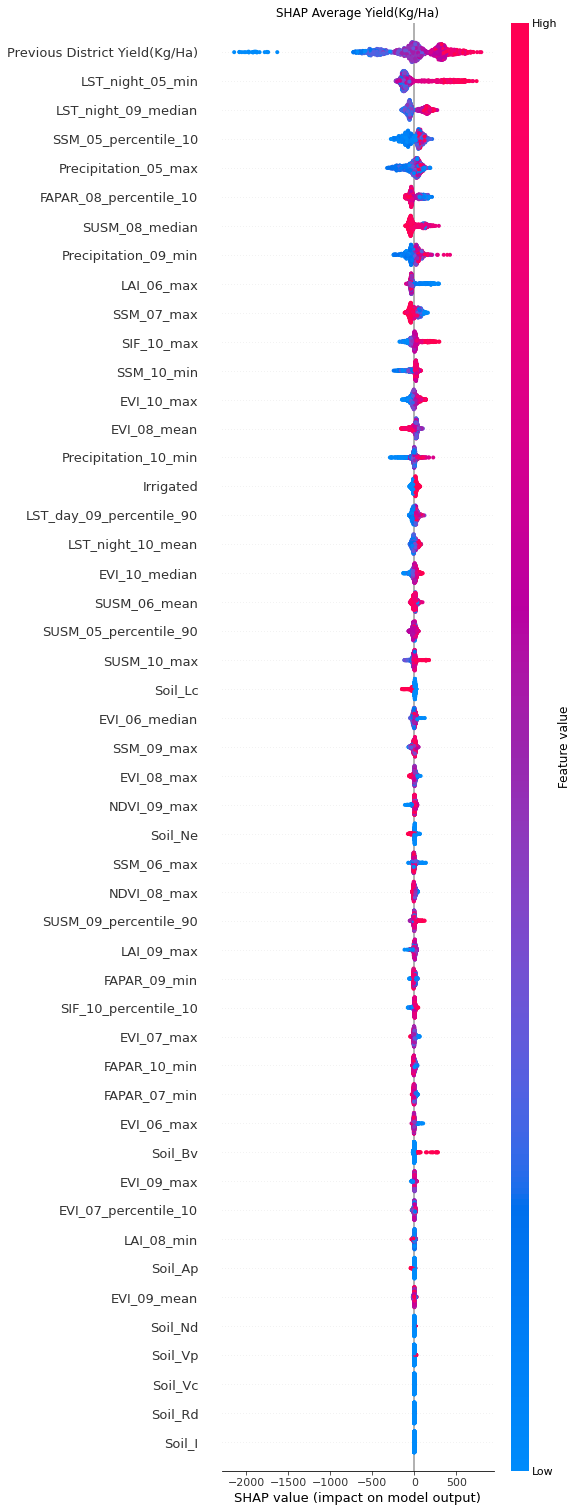

()

In [29]:
functions_model.SHAP_explainer(clf, test_geo, variables, 'Average Yield(Kg/Ha)', len(variables))